# Detectron2 for Elemental Segmentation

This walkthrough is inspired by the official colab detectron2 tutorial. We will be studying how we can use transfer learning to segment electron micrographs based on elemental composition!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

Lets look at a random image we've uploaded:


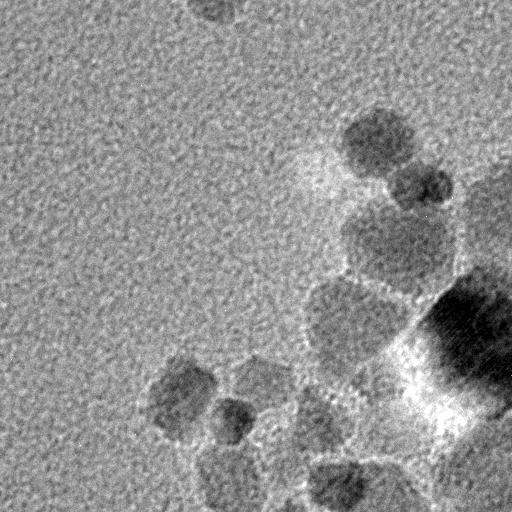

In [0]:
im = cv2.imread("./drive/My Drive/detectron2/untouched/3.jpg") #make sure this is the right path!
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [0]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:16, 10.9MB/s]                           


In [0]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([], device='cuda:0', size=(0, 4)))

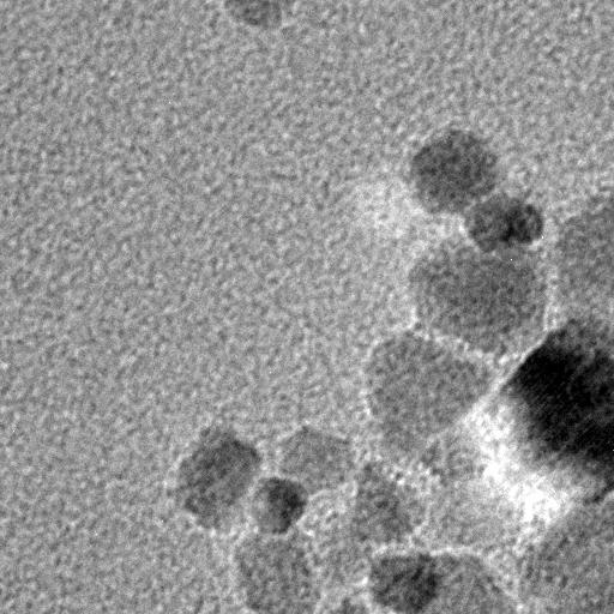

In [0]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

## Prepare the dataset

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train08", {}, "./drive/My Drive/detectron2/trainval8.json", "drive/My Drive/detectron2/trainimages8")
train_metadata08 = MetadataCatalog.get("train08")
train_dicts08 = DatasetCatalog.get("train08")

WARNING [05/02 08:08:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/02 08:08:42 d2.data.datasets.coco]: Loaded 8 images in COCO format from ./drive/My Drive/detectron2/trainval8.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



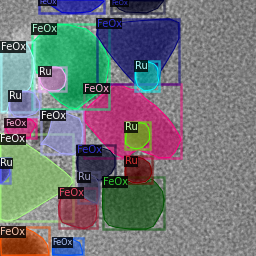

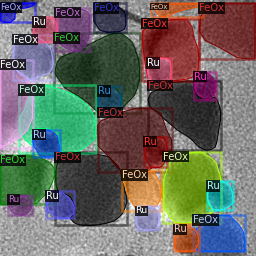

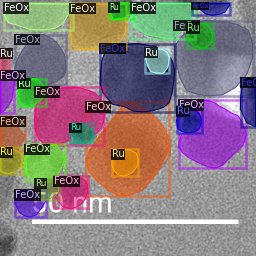

In [0]:
for d in random.sample(train_dicts_8, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train08",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg.DATASETS.TEST = ("train08", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

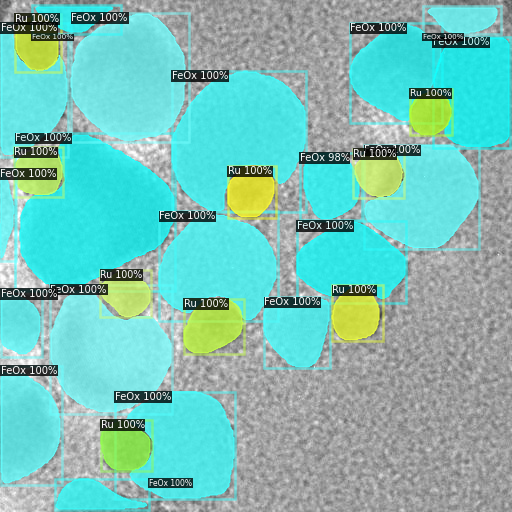

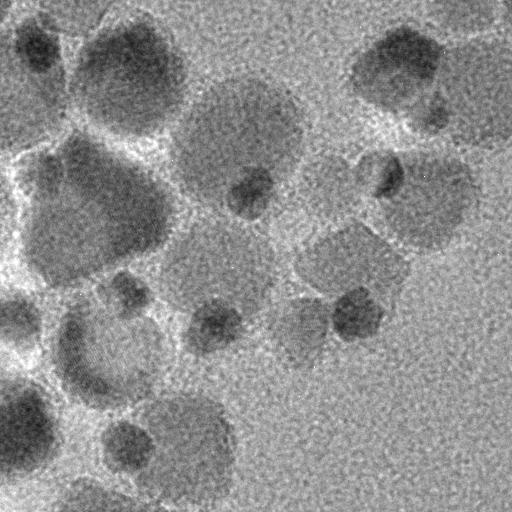

In [0]:
from detectron2.utils.visualizer import ColorMode
MetadataCatalog.get("train08").thing_colors = [(2,255,250), (129,250,22)]
im = cv2.imread("./drive/My Drive/detectron2/untouched/62.jpg") #make sure this is the right path!
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=train_metadata08, scale=1, instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2_imshow(im)

Working with 1 training examples now!

In [0]:
register_coco_instances("train1", {}, "./drive/My Drive/detectron2/trainval1.json", "drive/My Drive/detectron2/trainimages1")
train_metadata_1 = MetadataCatalog.get("train1")
train_dicts_1 = DatasetCatalog.get("train1")

WARNING [05/02 07:35:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/02 07:35:19 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./drive/My Drive/detectron2/trainval1.json


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg.DATASETS.TEST = ("train1", )
predictor = DefaultPredictor(cfg)

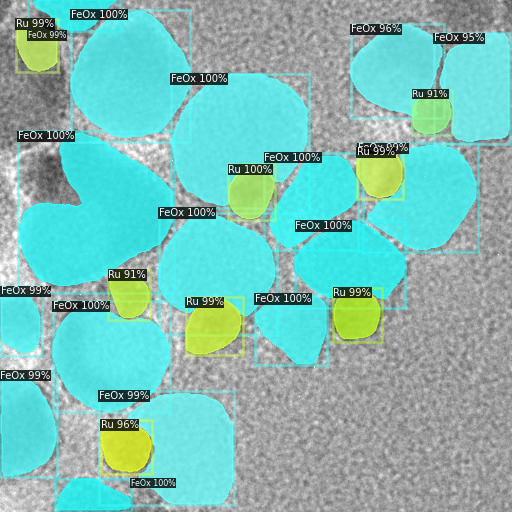

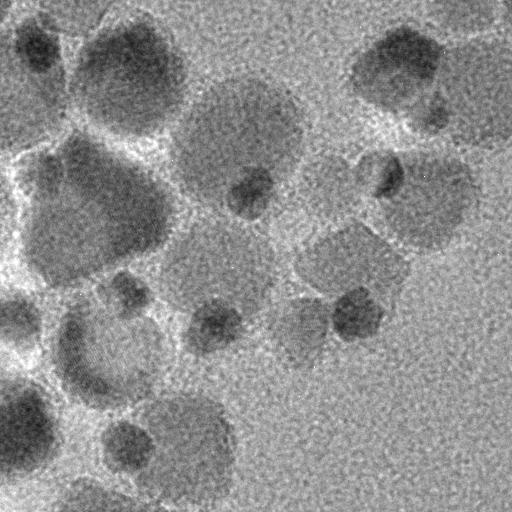

In [0]:
from detectron2.utils.visualizer import ColorMode
MetadataCatalog.get("train1").thing_colors = [(2,255,250), (129,250,22)]
im = cv2.imread("./drive/My Drive/detectron2/untouched/62.jpg") #make sure this is the right path!
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=train_metadata_1, scale=1, instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2_imshow(im)

Now with 4 training examples!


In [0]:
register_coco_instances("train4", {}, "./drive/My Drive/detectron2/trainval4.json", "drive/My Drive/detectron2/trainimages4")
train_metadata_4 = MetadataCatalog.get("train4")
train_dicts_4 = DatasetCatalog.get("train4")

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train4",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg.DATASETS.TEST = ("train4", )
predictor = DefaultPredictor(cfg)

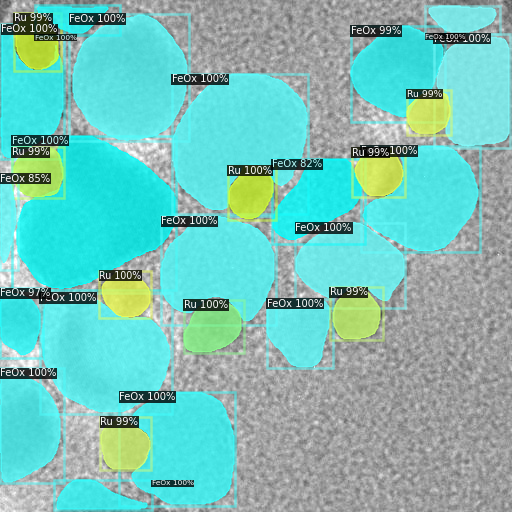

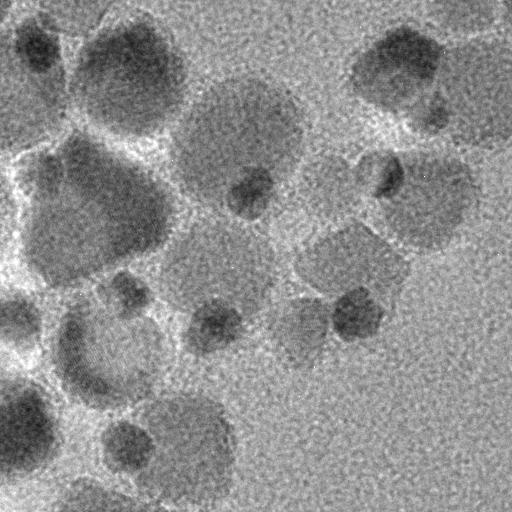

In [0]:
from detectron2.utils.visualizer import ColorMode
MetadataCatalog.get("train4").thing_colors = [(2,255,250), (129,250,22)]
im = cv2.imread("./drive/My Drive/detectron2/untouched/62.jpg") #make sure this is the right path!
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=train_metadata_4, scale=1, instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2_imshow(im)

Finally, 2 training examples!

In [0]:
register_coco_instances("train2", {}, "./drive/My Drive/detectron2/trainval2.json", "drive/My Drive/detectron2/trainimages2")
train_metadata_2 = MetadataCatalog.get("train2")
train_dicts_2 = DatasetCatalog.get("train2")

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg.DATASETS.TEST = ("train2", )
predictor = DefaultPredictor(cfg)

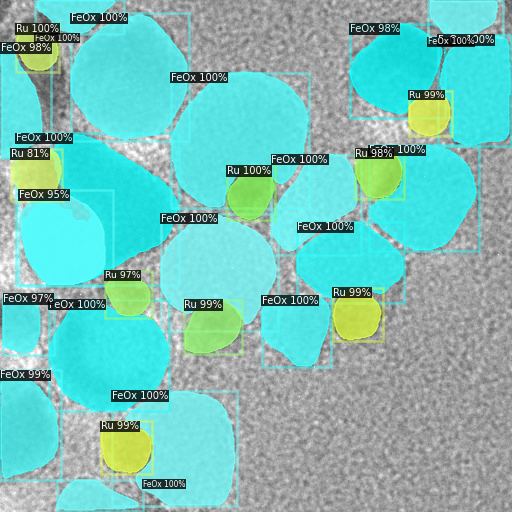

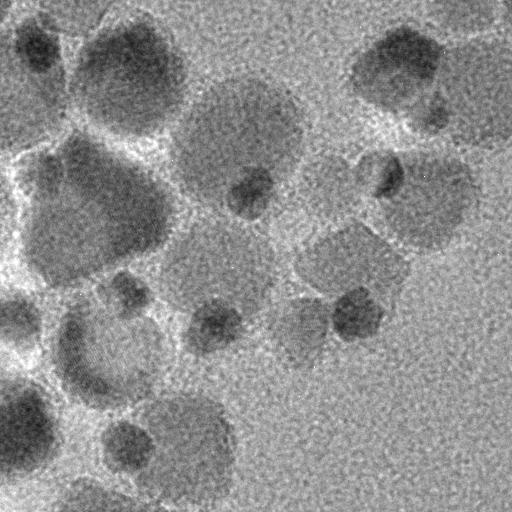

In [0]:
from detectron2.utils.visualizer import ColorMode
MetadataCatalog.get("train2").thing_colors = [(2,255,250), (129,250,22)]
im = cv2.imread("./drive/My Drive/detectron2/untouched/62.jpg") #make sure this is the right path!
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=train_metadata_2, scale=1, instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2_imshow(im)